In [90]:
def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


df = pd.read_csv('results/feature_vector.csv', index_col=0)
df = df[df['group'] != 'none_hearing']
label_names = ['angry','happy', 'neutral', 'sad'] #['neutral', 'angry']
df = subsample_labels(df, label_names)

labels = df['label']
group = df['group']
df.drop(['label', 'group'], axis=1, inplace=True)
df

,AU01_mean,AU01_std,AU01_e0_length,AU01_e0_intensity,AU01_e0_amount,AU01_e1_length,AU01_e1_intensity,AU01_e1_amount,AU01_e2_length,AU01_e2_intensity,...,AU17_std,AU17_e0_length,AU17_e0_intensity,AU17_e0_amount,AU17_e1_length,AU17_e1_intensity,AU17_e1_amount,AU17_e2_length,AU17_e2_intensity,AU17_e2_amount
0,0.345500,0.565072,2.0,0.190000,1.0,0.0,0.000000,0.0,8.0,1.433750,...,0.480786,0.0,0.000000,0.0,13.0,0.673846,1.0,12.0,1.280000,1.0
1,0.488837,0.645358,9.0,1.216667,1.0,6.0,1.190000,1.0,0.0,0.000000,...,0.438912,4.0,0.442500,1.0,1.0,0.430000,1.0,4.0,1.260000,1.0
2,0.130256,0.168015,0.0,0.000000,0.0,0.0,0.000000,0.0,3.0,0.473333,...,0.379025,0.0,0.000000,0.0,0.0,0.000000,0.0,12.0,0.877500,1.0
3,0.132766,0.154000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.247550,3.0,0.646667,1.0,1.0,0.760000,1.0,0.0,0.000000,0.0
4,0.118000,0.177830,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.233872,2.0,0.565000,1.0,0.0,0.000000,0.0,2.0,0.735000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.180440,0.305104,15.0,0.288667,1.0,0.0,0.000000,0.0,3.0,0.926667,...,0.322604,0.0,0.000000,0.0,6.0,1.218333,1.0,0.0,0.000000,0.0
256,0.192955,0.483305,2.0,1.810000,1.0,0.0,0.000000,0.0,0.0,0.000000,...,0.287683,0.0,0.000000,0.0,0.0,0.000000,0.0,4.0,0.822500,1.0
257,0.102958,0.191240,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.349594,0.0,0.000000,0.0,3.0,0.670000,1.0,8.0,0.818968,2.0
258,0.152667,0.249558,2.0,0.910000,1.0,6.0,0.401667,1.0,0.0,0.000000,...,0.351835,0.0,0.000000,0.0,5.0,1.072000,1.0,0.0,0.000000,0.0


In [144]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)

In [145]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf = RandomForestClassifier(criterion='entropy')
# cv_scores = cross_val_score(clf, df, groups, cv=10)
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.23076923 0.38461538 0.34615385 0.57692308 0.53846154 0.38461538
 0.42307692 0.46153846 0.5        0.30769231]
0.41538461538461535


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

clf = RandomForestClassifier(criterion='entropy')
clf.fit(df, labels)
feature_imp = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)

def plot_importance(clf):
    clf.fit(df, labels)
    feature_imp_ = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)
    feature_imp_ = feature_imp_[0:5]


    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    # plt.title("Hearing - Vs. None hearing")
    plt.legend()
    plt.show()

# plot_importance(clf)
len(feature_imp)

121

              precision    recall  f1-score   support

       angry       0.17      0.06      0.09        16
       happy       0.68      0.65      0.67        20
     neutral       0.33      0.26      0.29        19
         sad       0.32      0.52      0.39        23

    accuracy                           0.40        78
   macro avg       0.38      0.37      0.36        78
weighted avg       0.38      0.40      0.38        78

f1: 0.3612840068963502
prec: 0.375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


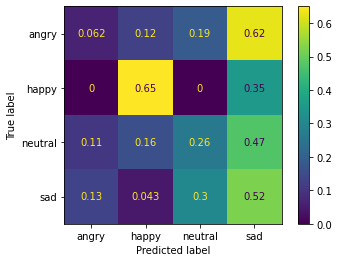

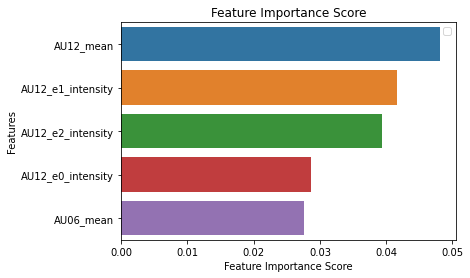

In [148]:
xtrain = X_train[feature_imp[0:19].index.to_list()]
xtest = X_test[feature_imp[0:19].index.to_list()]


clf = RandomForestClassifier(criterion='entropy', max_depth=5)
clf.fit(xtrain, y_train)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
plot_importance(clf)


In [131]:
# score per feature - over train - test split
# from tqdm import tqdm
# f1s = []
# prec = []
# for num_features in tqdm(range(5, 121)):
    
#     xtrain = subsample_features(X_train, feature_imp[0:num_features])
#     xtest = subsample_features(X_test, feature_imp[0:num_features])
#     clf = RandomForestClassifier(criterion='entropy', max_depth=5)
#     clf.fit(xtrain, y_train)
#     y_pred = clf.predict(xtest)
#     f1s.append(f1_score(y_test, y_pred, average='macro'))
#     prec.append(precision_score(y_test, y_pred, average='macro'))

# plt.plot(list(range(5,121)), f1s, label='F1')
# plt.plot(list(range(5,121)), prec, label='precision')
# plt.xlabel('Num of features')
# plt.ylabel('Score')
# plt.title('Evaluation over #features')
# plt.legend()


# print(f'features: {np.argmax(prec)} prec: {prec[np.argmax(prec)]} ')
# print(f'features: {np.argmax(f1s)} f1: {f1s[np.argmax(f1s)]} ')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.98s/it]

features: 19 cv: 0.45 


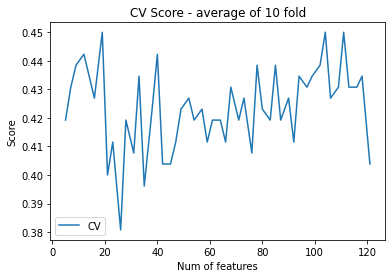

In [147]:
# cv score average per feature on the x -axis

cv_aver = []
fe_range = np.linspace(5, 121, 50).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=5)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()


max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, y)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


[Text(0.5, 0.875, 'AU12_e2_intensity <= 1.093\nentropy = 1.985\nsamples = 220\nvalue = [44, 55, 55, 66]\nclass = sad'),
 Text(0.25, 0.625, 'AU07_e1_intensity <= 0.169\nentropy = 1.808\nsamples = 156\nvalue = [35, 11, 49, 61]\nclass = sad'),
 Text(0.125, 0.375, 'AU04_e2_length <= 1.5\nentropy = 1.596\nsamples = 100\nvalue = [22, 1, 33, 44]\nclass = sad'),
 Text(0.0625, 0.125, 'entropy = 1.584\nsamples = 92\nvalue = [22, 1, 25, 44]\nclass = sad'),
 Text(0.1875, 0.125, 'entropy = 0.0\nsamples = 8\nvalue = [0, 0, 8, 0]\nclass = neutral'),
 Text(0.375, 0.375, 'AU12_std <= 0.383\nentropy = 1.971\nsamples = 56\nvalue = [13, 10, 16, 17]\nclass = sad'),
 Text(0.3125, 0.125, 'entropy = 1.856\nsamples = 44\nvalue = [12, 4, 11, 17]\nclass = sad'),
 Text(0.4375, 0.125, 'entropy = 1.325\nsamples = 12\nvalue = [1, 6, 5, 0]\nclass = happy'),
 Text(0.75, 0.625, 'AU06_e2_length <= 13.5\nentropy = 1.377\nsamples = 64\nvalue = [9, 44, 6, 5]\nclass = happy'),
 Text(0.625, 0.375, 'AU06_e2_length <= 1.25\nen

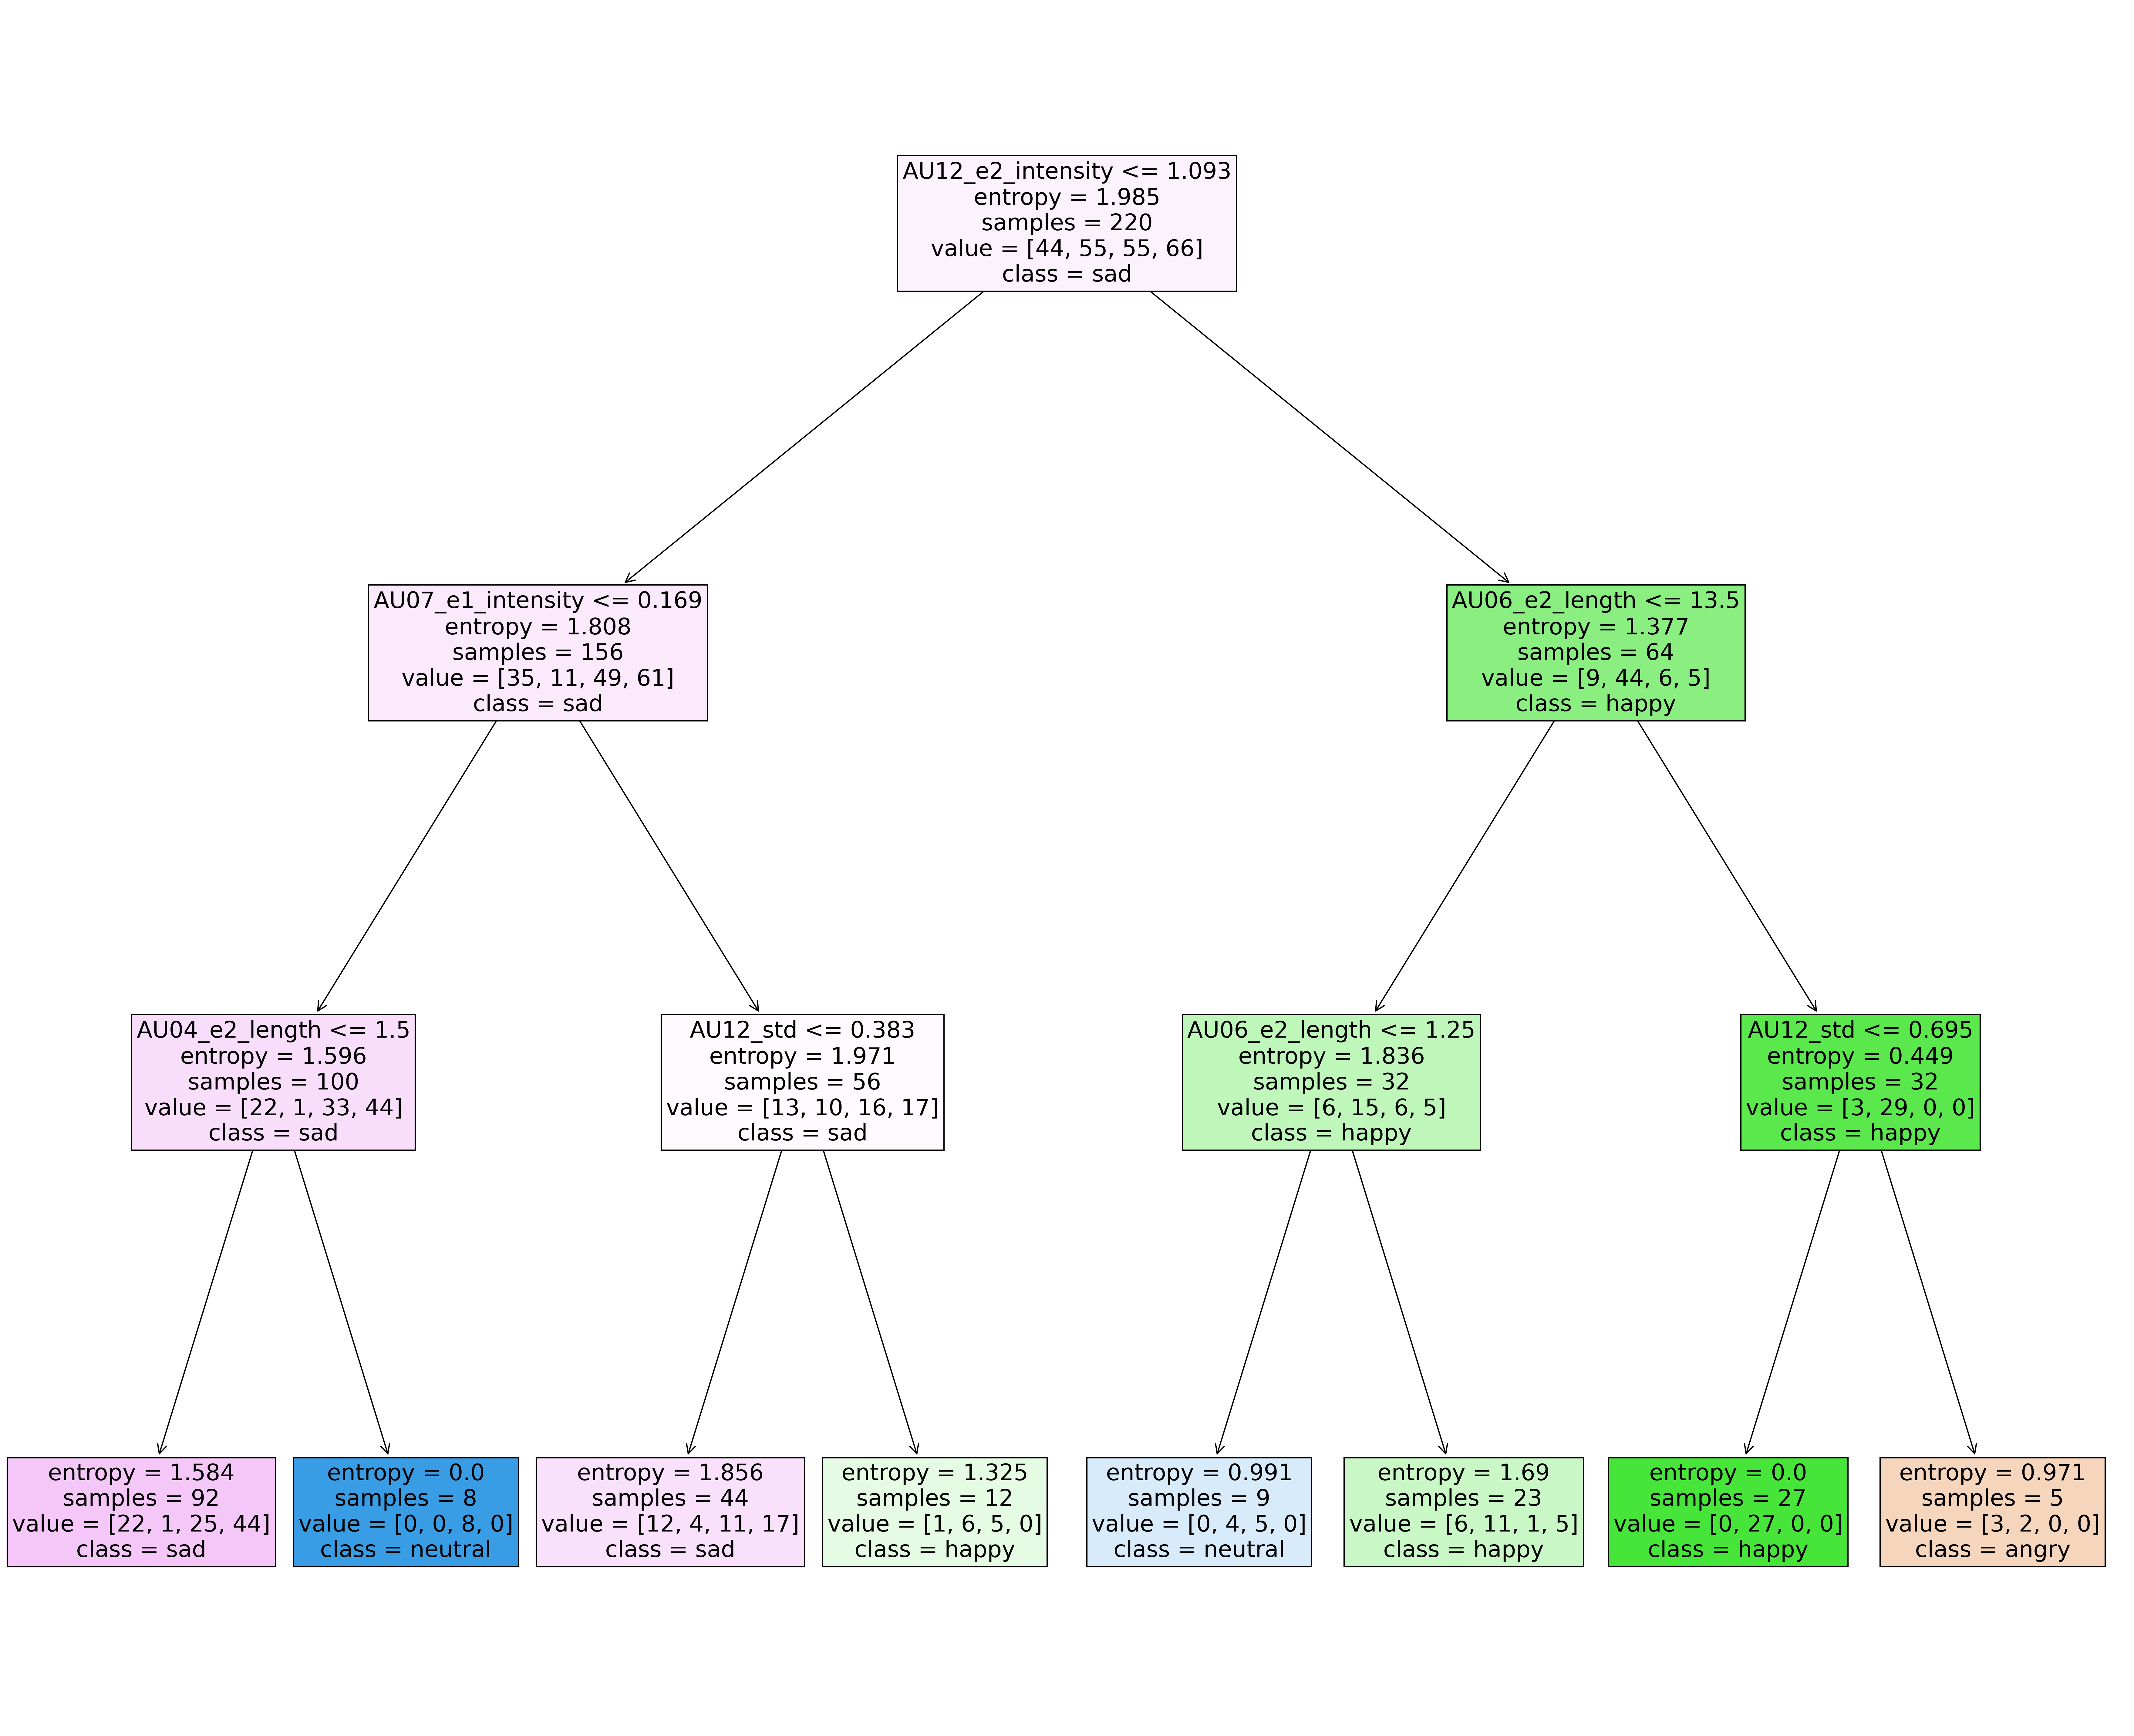

In [45]:
import matplotlib.pyplot as plt
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, y)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')
